# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns of our problem.

There are two main benifits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network acrhitecture which has already learned patterns on similar data to our own, then we can adapt those patters to our data.

In [79]:
# Are we using a GPU?
!nvidia-smi

Wed Oct 20 18:58:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8     3W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [80]:
# How many images are there in the folder?
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

we'll use the `ImageDataGenerator` class to load in our images in batches.

In [81]:
# Setup data imputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE  = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training Images')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical",
                                                          )

print('Testing Image')
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size = IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = "categorical")


Training Images
Found 750 images belonging to 10 classes.
Testing Image
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whist our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after trianing. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoints with the ModelCheckppoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [82]:
# Create TensorBoard callback (fucntionzied because we need to create a new one for model)
import datetime

def create_tensorbaord_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
 

>🔑**Note:** You can customize where your TensorBoard logs (model training metrics) get saved to whatever you like.
The `log_dir` parameter we've created above is only one options.    



## Creating model using TesnorFlow Hub

In the past we've used TensorFlow to create our own model layer by layer from scratch. 

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub. 

We can access pretrained models on. [Tensorboard](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for images classification, we found the following feature vector model link: [Model](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)

In [83]:
# Let's compare the following two models 
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [84]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [85]:
IMAGE_SHAPE +(3,)

(224, 224, 3)

In [86]:
# Let's maeke a create _model() function to create a model from URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Kearas Sequential model with it.
    
    Args:
        model_url (str): A TensorFlow Hub features extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.
    Returns:
        An uncompiled Keras Sequential model with mdoel_url as feature extractor 
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable = False,
                                             input_shape = IMAGE_SHAPE+(3,)) #Freeze the already learned patterns
    # Creaete the model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = "softmax", name = "output_layer")
        
    ])
    
    return model

### Creating and testing Resnet TensorFlow Hub Feature Extraction model

In [87]:
# Create Resnet model 
resnet_model = create_model(resnet_url,
                           num_classes=train_data_10_percent.num_classes)

In [88]:
# Compile our resnet model 
resnet_model.compile(loss= "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [89]:
# Fit the model
history = resnet_model.fit(train_data_10_percent,
                           epochs =5,
                           steps_per_epoch = len(train_data_10_percent),
                           validation_data= test_data,
                           validation_steps = len(test_data),
                           callbacks= [create_tensorbaord_callback(dir_name ='tensorflow_hub',
                                                                   experiment_name = "resnet50v2"
                                                                  )])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20211020-1858%S
Epoch 1/5
24/24 [==============================] - 18s 615ms/step - loss: 1.9918 - accuracy: 0.3253 - val_loss: 1.2300 - val_accuracy: 0.6132
Epoch 2/5
24/24 [==============================] - 13s 567ms/step - loss: 0.9073 - accuracy: 0.7133 - val_loss: 0.8853 - val_accuracy: 0.7152
Epoch 3/5
24/24 [==============================] - 13s 568ms/step - loss: 0.6330 - accuracy: 0.8147 - val_loss: 0.7774 - val_accuracy: 0.7444
Epoch 4/5
24/24 [==============================] - 13s 570ms/step - loss: 0.4792 - accuracy: 0.8827 - val_loss: 0.7071 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 13s 569ms/step - loss: 0.3816 - accuracy: 0.9107 - val_loss: 0.6920 - val_accuracy: 0.7728


In [90]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [91]:
resnet_model.evaluate(test_data)

79/79 [==============================] - 10s 130ms/step - loss: 0.6920 - accuracy: 0.7728


[0.6920227408409119, 0.7728000283241272]

Our transfer learning feature extractor model out perform ALL of the previous model we built by hand...(substantially) and in a quicker training time AND with only 10% of the trainig examples

In [92]:
# Let's create a function tp create the loss curves ]
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it 
def plot_loss_curves(history):
    """
    Return seperate loss curves for training and validtion loss
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    import matplotlib.pyplot as plt
    # Let's plot the loss and val_loss
    plt.figure()
    plt.plot(epochs , loss, label = ['training_loss'])
    plt.plot(epochs, val_loss, label = ['validaton_loss'])
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    # let's plot the accuracy and validation accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = ['training Accuracy'])
    plt.plot(epochs, val_accuracy, label=['validation Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

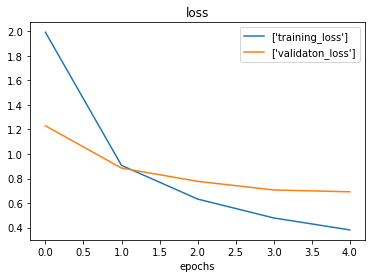

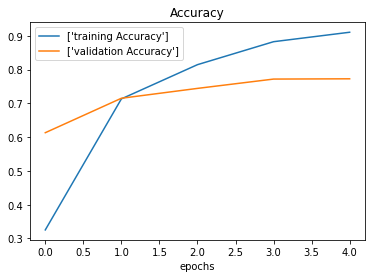

In [93]:
plot_loss_curves(history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [94]:
# Creaet EfficietNetB0 feature extractor model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

# Compile the EfficientNet model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                                                optimizer = tf.keras.optimizers.Adam(),
                                                metrics =['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit( train_data_10_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_10_percent),
                      validation_data = test_data,
                      validation_steps = len(test_data),
                      callbacks = [create_tensorbaord_callback(dir_name ="tensorflow_hub",
                                                               experiment_name = 'efficientNetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientNetb0/20211020-1900%S
Epoch 1/5
24/24 [==============================] - 17s 484ms/step - loss: 1.9287 - accuracy: 0.4133 - val_loss: 1.3433 - val_accuracy: 0.7168
Epoch 2/5
24/24 [==============================] - 9s 381ms/step - loss: 1.1086 - accuracy: 0.7587 - val_loss: 0.8903 - val_accuracy: 0.8120
Epoch 3/5
24/24 [==============================] - 9s 381ms/step - loss: 0.7806 - accuracy: 0.8373 - val_loss: 0.7092 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 9s 382ms/step - loss: 0.6230 - accuracy: 0.8627 - val_loss: 0.6180 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 9s 383ms/step - loss: 0.5244 - accuracy: 0.8947 - val_loss: 0.5636 - val_accuracy: 0.8596


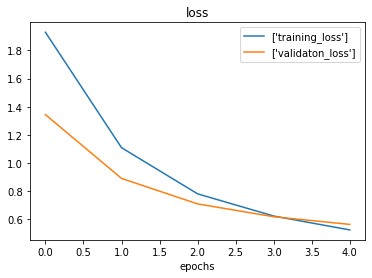

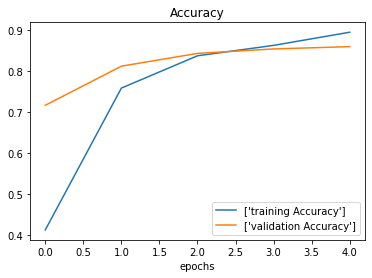

In [95]:
plot_loss_curves(efficientnet_history)

In [96]:
efficientnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_13 (KerasLayer)  (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [97]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [98]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning**- using an existing model with no changes what so ever (e.g. using ImageNet mdoel on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** - transfer learning - use the prelearned patterns of an exisitng model (e.g. EfficienNetB0 trained on ImageNet) and adjust the output layer for your own problems (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learing - use the prelearned patterns of an existing model and "fine-tune many or all of the underlying layers (including new output layers)

## Comparing our model results using TensorBoard

>🔑**Note:** when you upload things to TensorBoard.dev, your experimnets are public. So if you're runnning private experiments(thing's you don't want others to see) do not upload them to TensoBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet5OV2" \
--description "comparing two different TF hub feature extraction model architecture suing 10% of the training data" \
--one_shot